In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [82]:
trades = ["data/trades_round_1_day_-2_nn.csv",
          "data/trades_round_1_day_-1_nn.csv",
          "data/trades_round_1_day_0_nn.csv"]

In [3]:
price_2 = pd.read_csv("data/prices_round_1_day_-2.csv", sep=";")
price_1 = pd.read_csv("data/prices_round_1_day_-1.csv", sep=";")
price_0 = pd.read_csv("data/prices_round_1_day_0.csv", sep=";")
price_d2 = pd.read_csv("data/prices_day_2.csv", sep=";")
price_d3 = pd.read_csv("data/prices_day_3.csv", sep=";")
price_d4 = pd.read_csv("data/prices_day_4.csv", sep=";")

prices = [price_2, price_1, price_0, price_d2, price_d3, price_d4]

In [4]:
prices_all = prices[0]
for p in prices[1:]:
    prices_all = pd.concat((prices_all, p), ignore_index=True)

prices_am = prices_all.loc[prices_all["product"]=="AMETHYSTS"].reset_index().drop("index", axis=1)
prices_st = prices_all.loc[prices_all["product"]=="STARFRUIT"].reset_index().drop("index", axis=1)

In [6]:
prices.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'day;timestamp;product;bid_price_1;bid_volume_1;bid_price_2;bid_volume_2;bid_price_3;bid_volume_3;ask_price_1;ask_volume_1;ask_price_2;ask_volume_2;ask_price_3;ask_volume_3;mid_price;profit_and_loss'],
      dtype='object')

In [7]:
trade_2 = pd.read_csv(trades[0], sep=";")
trade_1 = pd.read_csv(trades[1], sep=";")
trade_0 = pd.read_csv(trades[2], sep=";")

In [6]:
trades = pd.concat((pd.concat((trade_2, trade_1), ignore_index=True)
                    , trade_0), ignore_index=True)
trades_am = trades.loc[trades["symbol"]=="AMETHYSTS"].reset_index().drop("index", axis=1)
trades_st = trades.loc[trades["symbol"]=="STARFRUIT"].reset_index().drop("index", axis=1)

Compute Simple Moving Average (SMA)

In [5]:
def SMA(df, period=20):
    sma = pd.DataFrame()
    sma["best bid"] = df["bid_price_1"].rolling(window=period).mean()
    sma["best ask"] = df["ask_price_1"].rolling(window=period).mean()
    sma["mid price"] = df["mid_price"].rolling(window=period).mean()

    return sma

## STARFRUIT

In [6]:
times1 = prices_st.loc[prices_st["day"]==-2]["timestamp"].to_numpy()
times2 = prices_st.loc[prices_st["day"]==2]["timestamp"].to_numpy()

times = list(times1)
for i in range(2):
    times += list(times1 + times[-1] + 100)
for i in range(2):
    times += list(times2 + times[-1] + 100)
for i in range(2):
    times += list(times1 + times[-1] + 100)

Interpolate missing data linearly

In [7]:
start = prices_st.iloc[29999]["mid_price"]
end = prices_st.iloc[30000]["mid_price"]
xs = times[30001:31001]
grad = (end - start) / (xs[-1] - xs[0])
ys = grad * (xs - xs[-1]) + end

In [8]:
prices_st_interpolated = np.concatenate((prices_st["mid_price"].to_numpy()[:30000], ys))
prices_st_interpolated = np.concatenate((prices_st_interpolated, prices_st["mid_price"].to_numpy()[30000:]))

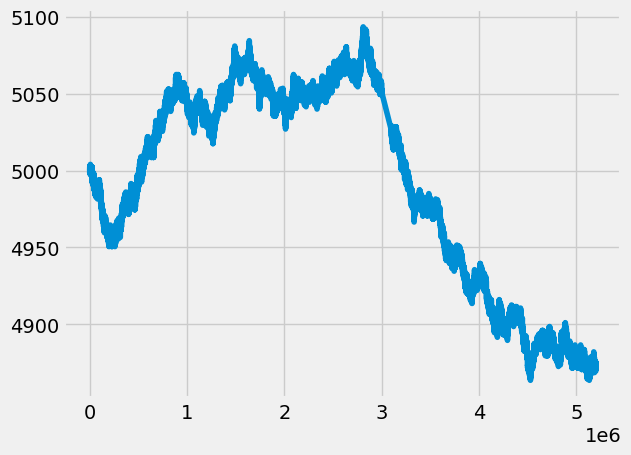

In [9]:
plt.plot(times, prices_st_interpolated)

In [35]:
sma50 = price_d3.loc[price_d3["product"]=="STARFRUIT"]["mid_price"].rolling(50).mean()
sma200 = price_d3.loc[price_d3["product"]=="STARFRUIT"]["mid_price"].rolling(200).mean()

sma200 = sma200.dropna().to_numpy()
sma50 = sma50[199:].to_numpy()

In [56]:
buy = []
sell = []
shorter_below = False
for i in range(len(sma200)):
    if sma200[i] > sma50[i]:
        if not shorter_below:
            sell.append(i)
        shorter_below = True
    elif sma200[i] < sma50[i]:
        if shorter_below:
            buy.append(i)
        shorter_below = False

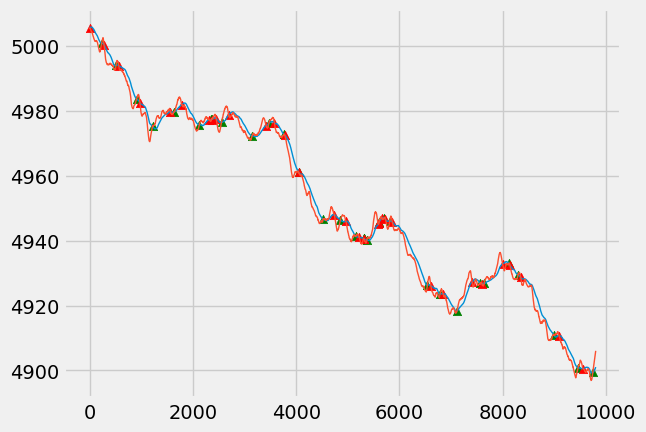

In [58]:
plt.plot(sma200, lw=1)
plt.plot(sma50, lw=1)
plt.scatter(buy, sma50[buy], marker="^", color='g')
plt.scatter(sell, sma50[sell], marker="^", color='r')